<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/LeafDataSet/Test_experiments/inceptionV3LFC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications.inception_v3 import InceptionV3
 
 
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.6.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datasetpath = '/content/drive/MyDrive/leaf classification'
lists = os.listdir(datasetpath)
labels = []
file_lst = []
 
for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(df)


                                         path           label
0     Gray_Leaf_Spot/Corn_Gray_Spot (106).JPG  Gray_Leaf_Spot
1     Gray_Leaf_Spot/Corn_Gray_Spot (105).JPG  Gray_Leaf_Spot
2     Gray_Leaf_Spot/Corn_Gray_Spot (101).JPG  Gray_Leaf_Spot
3     Gray_Leaf_Spot/Corn_Gray_Spot (104).JPG  Gray_Leaf_Spot
4       Gray_Leaf_Spot/Corn_Gray_Spot (1).jpg  Gray_Leaf_Spot
...                                       ...             ...
4192  Common_Rust/Corn_Common_Rust (1277).jpg     Common_Rust
4193  Common_Rust/Corn_Common_Rust (1275).jpg     Common_Rust
4194  Common_Rust/Corn_Common_Rust (1280).jpg     Common_Rust
4195  Common_Rust/Corn_Common_Rust (1279).jpg     Common_Rust
4196  Common_Rust/Corn_Common_Rust (1269).jpg     Common_Rust

[4197 rows x 2 columns]


In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.3,shuffle = True, random_state=42)
print(train_df )
print(validation_df)

                                         path           label
1226             Blight/Corn_Blight (693).JPG          Blight
1626            Blight/Corn_Blight (1069).JPG          Blight
3990  Common_Rust/Corn_Common_Rust (1084).JPG     Common_Rust
1398             Blight/Corn_Blight (850).JPG          Blight
1767            Healthy/Corn_Health (150).jpg         Healthy
...                                       ...             ...
3444   Common_Rust/Corn_Common_Rust (599).JPG     Common_Rust
466   Gray_Leaf_Spot/Corn_Gray_Spot (515).JPG  Gray_Leaf_Spot
3092   Common_Rust/Corn_Common_Rust (291).JPG     Common_Rust
3772   Common_Rust/Corn_Common_Rust (888).JPG     Common_Rust
860              Blight/Corn_Blight (348).jpg          Blight

[2937 rows x 2 columns]
                                         path           label
149   Gray_Leaf_Spot/Corn_Gray_Spot (216).jpg  Gray_Leaf_Spot
2028            Healthy/Corn_Health (370).jpg         Healthy
3770   Common_Rust/Corn_Common_Rust (885).JPG

In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/leaf classification',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 2937 validated image filenames belonging to 4 classes.
Found 1260 validated image filenames belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
class_number = 4
def build_model_graph(class_number=class_number):
  base_model = InceptionV3(weights='imagenet', include_top=False,input_shape = (224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(class_number, activation='softmax')(x)
  model = Model(base_model.input, predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
92/92 [==============================] - 116s 1s/step - loss: 0.6689 - accuracy: 0.7446 - val_loss: 0.3707 - val_accuracy: 0.8238
Epoch 2/15
92/92 [==============================] - 61s 659ms/step - loss: 0.2143 - accuracy: 0.9244 - val_loss: 0.2405 - val_accuracy: 0.9111
Epoch 3/15
92/92 [==============================] - 61s 659ms/step - loss: 0.1078 - accuracy: 0.9683 - val_loss: 0.1669 - val_accuracy: 0.9389
Epoch 4/15
92/92 [==============================] - 60s 656ms/step - loss: 0.0556 - accuracy: 0.9837 - val_loss: 0.1765 - val_accuracy: 0.9429
Epoch 5/15
92/92 [==============================] - 61s 659ms/step - loss: 0.0274 - accuracy: 0.9959 - val_loss: 0.1724 - val_accuracy: 0.9468
Epoch 6/15
92/92 [==============================] - 60s 657ms/step - loss: 0.0210 - accuracy: 0.9959 - val_loss: 0.1720 - val_accuracy: 0.9468
Epoch 7/15
92/92 [==============================] - 61s 659ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 0.1848 - val_accuracy: 0.9452
E

In [ ]:
results = '/content/drive/MyDrive/PlantClassification/Results'
os.mkdir(results) 

In [ ]:
leafclassificationDataSet = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet'
os.mkdir(leafclassificationDataSet) 

In [ ]:
InceptionV3Arch = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/InceptionV3Arch'
os.mkdir(InceptionV3Arch) 

In [ ]:
target_dir = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/InceptionV3Arch'
architecture_name = "InceptionV3Arch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')

In [ ]:
print(hist.history)

{'loss': [0.6688711643218994, 0.21429678797721863, 0.10782460123300552, 0.055592674762010574, 0.0273510180413723, 0.020973673090338707, 0.02138642407953739, 0.011858005076646805, 0.012799803167581558, 0.010752780362963676, 0.01059357076883316, 0.008379523642361164, 0.006628790404647589, 0.005897118244320154, 0.01061003003269434], 'accuracy': [0.7446373701095581, 0.9244126677513123, 0.9683350324630737, 0.9836567640304565, 0.9959142208099365, 0.9959142208099365, 0.9948927760124207, 0.9976165890693665, 0.9976165890693665, 0.9976165890693665, 0.9969356656074524, 0.9979571104049683, 0.9993190169334412, 0.9979571104049683, 0.9972761273384094], 'val_loss': [0.3706889748573303, 0.2405056357383728, 0.16685836017131805, 0.1764788031578064, 0.1723574548959732, 0.17204469442367554, 0.18484939634799957, 0.18678492307662964, 0.2040702998638153, 0.20614662766456604, 0.2103307843208313, 0.22357405722141266, 0.20138594508171082, 0.21815642714500427, 0.20376744866371155], 'val_accuracy': [0.823809504508

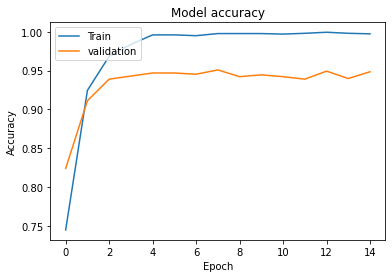

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [ ]:
hist = pd.DataFrame(hist.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/InceptionV3Arch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/train.csv')

In [ ]:
validation_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/validation.csv')

In [ ]:
model= model_load()

In [ ]:
img_path = '/content/drive/MyDrive/leaf classification/Common_Rust/Corn_Common_Rust (10).jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = (img_batch)*(1./255)

result = model.predict(img_preprocessed)
print(result)

[[6.8318499e-05 9.9980885e-01 7.8166959e-05 4.4736054e-05]]


In [ ]:
index_max=result.argmax(axis=-1)
print(index_max)

[1]


In [ ]:
print(train_generator.class_indices)

{'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
model = load_model('/content/drive/MyDrive/PlantClassification/Results/leafclassificationDataSet/InceptionV3Arch/InceptionV3Arch.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________